In [1]:
import matplotlib.pyplot as plt
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars
import plotly.io as pio

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.manifold import TSNE
import plotly.express as px

In [2]:
data_dir = 'dataset'
### With these commands the train and test datasets, respectively, are downloaded
### automatically and stored in the local "data_dir" directory.
train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw




Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw




Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw




Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning:

The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)



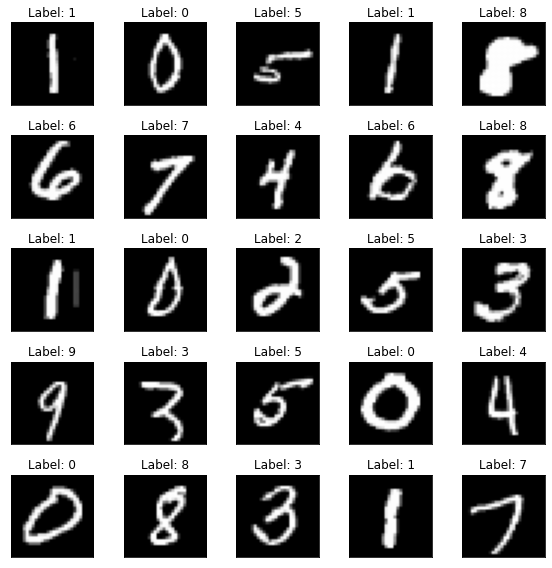

In [3]:
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

In [4]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

In [5]:
m=len(train_dataset)

#random_split randomly split a dataset into non-overlapping new datasets of given lengths
#train (55,000 images), val split (5,000 images)
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

batch_size=256

# The dataloaders handle shuffling, batching, etc...
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

## 1 Define Encoder and Decoder classes

In [6]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            #nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            #nn.BatchNorm2d(32),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x

In [7]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

## 2 initialize models, loss and optimizer

In [30]:
### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 4

encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)

In [31]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001 # Learning rate


params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

optim = torch.optim.Adam(params_to_optimize, lr=lr)

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)
#model.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

## 3 Train model

In [43]:
im = test_dataset[0][0].unsqueeze(0)
a = im + torch.randn_like(im)*0.3
print(a)

tensor([[[[ 4.7783e-01, -5.7324e-01,  2.6920e-01,  1.4469e-01,  1.8026e-01,
            8.0348e-02, -2.3348e-01,  1.7488e-01,  8.5685e-02,  1.1993e-01,
           -2.1309e-01,  2.3103e-01, -2.2989e-01,  1.9080e-01,  1.7219e-01,
           -4.3548e-02,  1.7771e-01, -5.8207e-02, -5.5810e-01, -1.0561e-01,
           -7.1347e-02,  2.5158e-01, -6.4452e-01, -6.0022e-02,  3.6977e-02,
           -1.1146e-02,  4.4660e-01, -5.8863e-02],
          [ 1.3794e-01, -2.8011e-01,  3.8707e-01, -6.6026e-02,  3.8489e-01,
            1.0665e-01, -1.1693e-01, -5.8967e-01, -3.5244e-01, -8.6981e-02,
            3.1456e-01,  4.0869e-01, -3.8633e-01, -2.0754e-01,  1.6101e-01,
           -9.4646e-02,  3.4963e-02, -2.3370e-01,  7.7369e-01,  1.8519e-01,
            3.1121e-01,  4.9699e-01, -1.6117e-02,  4.6134e-03, -5.1656e-01,
           -3.7104e-01,  3.8886e-01,  5.4441e-01],
          [ 4.0300e-01,  5.2264e-01,  1.6793e-01, -6.3913e-02,  2.1706e-01,
            2.1279e-01, -1.5646e-01,  2.1166e-01, -6.4673e-02,

In [44]:
b = torch.clip(a,0.,1.)
print(b)

tensor([[[[0.4778, 0.0000, 0.2692, 0.1447, 0.1803, 0.0803, 0.0000, 0.1749,
           0.0857, 0.1199, 0.0000, 0.2310, 0.0000, 0.1908, 0.1722, 0.0000,
           0.1777, 0.0000, 0.0000, 0.0000, 0.0000, 0.2516, 0.0000, 0.0000,
           0.0370, 0.0000, 0.4466, 0.0000],
          [0.1379, 0.0000, 0.3871, 0.0000, 0.3849, 0.1067, 0.0000, 0.0000,
           0.0000, 0.0000, 0.3146, 0.4087, 0.0000, 0.0000, 0.1610, 0.0000,
           0.0350, 0.0000, 0.7737, 0.1852, 0.3112, 0.4970, 0.0000, 0.0046,
           0.0000, 0.0000, 0.3889, 0.5444],
          [0.4030, 0.5226, 0.1679, 0.0000, 0.2171, 0.2128, 0.0000, 0.2117,
           0.0000, 0.0000, 0.3505, 0.7072, 0.0674, 0.1057, 0.0000, 0.2216,
           0.3712, 0.1630, 0.0000, 0.2233, 0.0000, 0.2402, 0.1093, 0.0534,
           0.0000, 0.0000, 0.1544, 0.0000],
          [0.6204, 0.0000, 0.2642, 0.0000, 0.7762, 0.3572, 0.0000, 0.0982,
           0.1844, 0.0000, 0.0737, 0.0000, 0.4533, 0.0000, 0.0000, 0.0000,
           0.1246, 0.0000, 0.0000, 0.0000, 

In [25]:
def add_noise(inputs,noise_factor=0.3):
     noise = inputs+torch.randn_like(inputs)*noise_factor
     noise = torch.clip(noise,0.,1.)
     return noise

In [26]:
### Training function
def train_epoch_den(encoder, decoder, device, dataloader, loss_fn, optimizer,noise_factor=0.3):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_noisy = add_noise(image_batch,noise_factor)
        image_noisy = image_noisy.to(device)    
        # Encode data
        encoded_data = encoder(image_noisy)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_noisy)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [27]:
### Testing function
def test_epoch_den(encoder, decoder, device, dataloader, loss_fn,noise_factor=0.3):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_noisy = add_noise(image_batch,noise_factor)
            image_noisy = image_noisy.to(device)
            # Encode data
            encoded_data = encoder(image_noisy)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [28]:
def plot_ae_outputs_den(encoder,decoder,n=5,noise_factor=0.3):
    plt.figure(figsize=(10,4.5))
    for i in range(n):

      ax = plt.subplot(3,n,i+1)
      img = test_dataset[i][0].unsqueeze(0)
      image_noisy = add_noise(img,noise_factor)     
      image_noisy = image_noisy.to(device)

      encoder.eval()
      decoder.eval()

      with torch.no_grad():
         rec_img  = decoder(encoder(image_noisy))

      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(3, n, i + 1 + n)
      plt.imshow(image_noisy.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Corrupted images')

      ax = plt.subplot(3, n, i + 1 + n + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.7, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)     
    plt.show()   

EPOCH 1/30
	 partial train loss (single batch): 0.189325
	 partial train loss (single batch): 0.184500
	 partial train loss (single batch): 0.179148
	 partial train loss (single batch): 0.175384
	 partial train loss (single batch): 0.172518
	 partial train loss (single batch): 0.169707
	 partial train loss (single batch): 0.167269
	 partial train loss (single batch): 0.165303
	 partial train loss (single batch): 0.163445
	 partial train loss (single batch): 0.161754
	 partial train loss (single batch): 0.160365
	 partial train loss (single batch): 0.158522
	 partial train loss (single batch): 0.157137
	 partial train loss (single batch): 0.155976
	 partial train loss (single batch): 0.154286
	 partial train loss (single batch): 0.152429
	 partial train loss (single batch): 0.150710
	 partial train loss (single batch): 0.149841
	 partial train loss (single batch): 0.148491
	 partial train loss (single batch): 0.146915
	 partial train loss (single batch): 0.145468
	 partial train loss (s

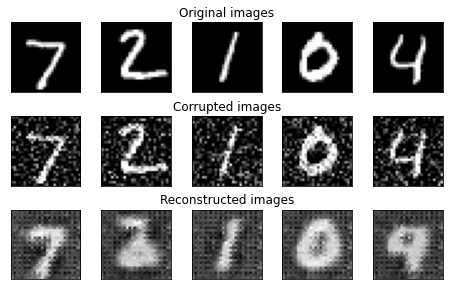

EPOCH 2/30
	 partial train loss (single batch): 0.067462
	 partial train loss (single batch): 0.066469
	 partial train loss (single batch): 0.067502
	 partial train loss (single batch): 0.067707
	 partial train loss (single batch): 0.066665
	 partial train loss (single batch): 0.066770
	 partial train loss (single batch): 0.067021
	 partial train loss (single batch): 0.066425
	 partial train loss (single batch): 0.066687
	 partial train loss (single batch): 0.066101
	 partial train loss (single batch): 0.066308
	 partial train loss (single batch): 0.066283
	 partial train loss (single batch): 0.066119
	 partial train loss (single batch): 0.066267
	 partial train loss (single batch): 0.065717
	 partial train loss (single batch): 0.066599
	 partial train loss (single batch): 0.064845
	 partial train loss (single batch): 0.065715
	 partial train loss (single batch): 0.065776
	 partial train loss (single batch): 0.065197
	 partial train loss (single batch): 0.065081
	 partial train loss (s

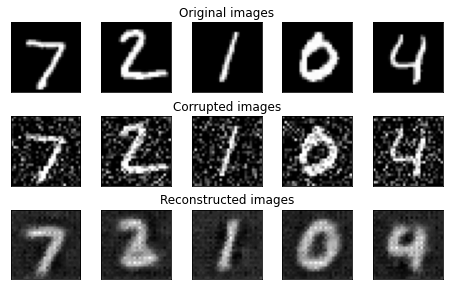

EPOCH 3/30
	 partial train loss (single batch): 0.058969
	 partial train loss (single batch): 0.057727
	 partial train loss (single batch): 0.058814
	 partial train loss (single batch): 0.059571
	 partial train loss (single batch): 0.058956
	 partial train loss (single batch): 0.058262
	 partial train loss (single batch): 0.058845
	 partial train loss (single batch): 0.058232
	 partial train loss (single batch): 0.058682
	 partial train loss (single batch): 0.058581
	 partial train loss (single batch): 0.058421
	 partial train loss (single batch): 0.058586
	 partial train loss (single batch): 0.058777
	 partial train loss (single batch): 0.058313
	 partial train loss (single batch): 0.057983
	 partial train loss (single batch): 0.058509
	 partial train loss (single batch): 0.057438
	 partial train loss (single batch): 0.058219
	 partial train loss (single batch): 0.057839
	 partial train loss (single batch): 0.057464
	 partial train loss (single batch): 0.057749
	 partial train loss (s

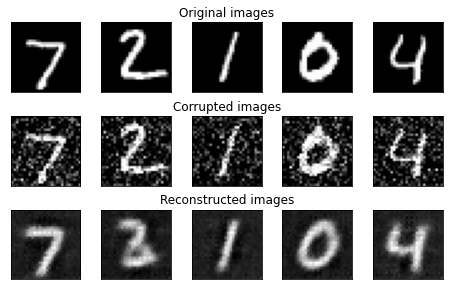

EPOCH 4/30
	 partial train loss (single batch): 0.054881
	 partial train loss (single batch): 0.054131
	 partial train loss (single batch): 0.055018
	 partial train loss (single batch): 0.055918
	 partial train loss (single batch): 0.055436
	 partial train loss (single batch): 0.054407
	 partial train loss (single batch): 0.054680
	 partial train loss (single batch): 0.053963
	 partial train loss (single batch): 0.055041
	 partial train loss (single batch): 0.054635
	 partial train loss (single batch): 0.054725
	 partial train loss (single batch): 0.055245
	 partial train loss (single batch): 0.054832
	 partial train loss (single batch): 0.054429
	 partial train loss (single batch): 0.053999
	 partial train loss (single batch): 0.054751
	 partial train loss (single batch): 0.053793
	 partial train loss (single batch): 0.054746
	 partial train loss (single batch): 0.054554
	 partial train loss (single batch): 0.053655
	 partial train loss (single batch): 0.053922
	 partial train loss (s

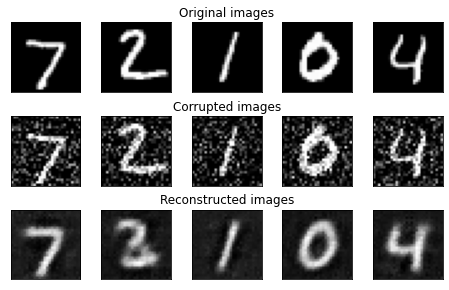

EPOCH 5/30
	 partial train loss (single batch): 0.053119
	 partial train loss (single batch): 0.052506
	 partial train loss (single batch): 0.053059
	 partial train loss (single batch): 0.053982
	 partial train loss (single batch): 0.053553
	 partial train loss (single batch): 0.052694
	 partial train loss (single batch): 0.053191
	 partial train loss (single batch): 0.053085
	 partial train loss (single batch): 0.053674
	 partial train loss (single batch): 0.053595
	 partial train loss (single batch): 0.053254
	 partial train loss (single batch): 0.053863
	 partial train loss (single batch): 0.053324
	 partial train loss (single batch): 0.053070
	 partial train loss (single batch): 0.052792
	 partial train loss (single batch): 0.053494
	 partial train loss (single batch): 0.052443
	 partial train loss (single batch): 0.053646
	 partial train loss (single batch): 0.052860
	 partial train loss (single batch): 0.052256
	 partial train loss (single batch): 0.053058
	 partial train loss (s

EPOCH 6/30
	 partial train loss (single batch): 0.052649
	 partial train loss (single batch): 0.051336
	 partial train loss (single batch): 0.052536
	 partial train loss (single batch): 0.053505
	 partial train loss (single batch): 0.052754
	 partial train loss (single batch): 0.051842
	 partial train loss (single batch): 0.052896
	 partial train loss (single batch): 0.052229
	 partial train loss (single batch): 0.052966
	 partial train loss (single batch): 0.052852
	 partial train loss (single batch): 0.052191
	 partial train loss (single batch): 0.053085
	 partial train loss (single batch): 0.053368
	 partial train loss (single batch): 0.052587
	 partial train loss (single batch): 0.052303
	 partial train loss (single batch): 0.053041
	 partial train loss (single batch): 0.051491
	 partial train loss (single batch): 0.052617
	 partial train loss (single batch): 0.052048
	 partial train loss (single batch): 0.051742
	 partial train loss (single batch): 0.052161
	 partial train loss (s

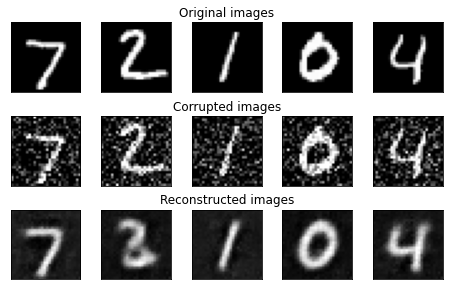

EPOCH 7/30
	 partial train loss (single batch): 0.052124
	 partial train loss (single batch): 0.051108
	 partial train loss (single batch): 0.052338
	 partial train loss (single batch): 0.053497
	 partial train loss (single batch): 0.052484
	 partial train loss (single batch): 0.051803
	 partial train loss (single batch): 0.052149
	 partial train loss (single batch): 0.051861
	 partial train loss (single batch): 0.052311
	 partial train loss (single batch): 0.052756
	 partial train loss (single batch): 0.051957
	 partial train loss (single batch): 0.052490
	 partial train loss (single batch): 0.052699
	 partial train loss (single batch): 0.052242
	 partial train loss (single batch): 0.051514
	 partial train loss (single batch): 0.052610
	 partial train loss (single batch): 0.051516
	 partial train loss (single batch): 0.052032
	 partial train loss (single batch): 0.051939
	 partial train loss (single batch): 0.051489
	 partial train loss (single batch): 0.051703
	 partial train loss (s

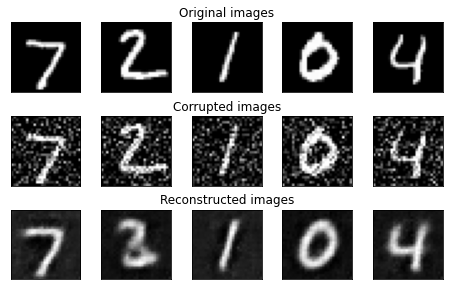

EPOCH 8/30
	 partial train loss (single batch): 0.051609
	 partial train loss (single batch): 0.051361
	 partial train loss (single batch): 0.052148
	 partial train loss (single batch): 0.052839
	 partial train loss (single batch): 0.052079
	 partial train loss (single batch): 0.051560
	 partial train loss (single batch): 0.051949
	 partial train loss (single batch): 0.051576
	 partial train loss (single batch): 0.052082
	 partial train loss (single batch): 0.052182
	 partial train loss (single batch): 0.051309
	 partial train loss (single batch): 0.051982
	 partial train loss (single batch): 0.052070
	 partial train loss (single batch): 0.052150
	 partial train loss (single batch): 0.051218
	 partial train loss (single batch): 0.052038
	 partial train loss (single batch): 0.051079
	 partial train loss (single batch): 0.052168
	 partial train loss (single batch): 0.051426
	 partial train loss (single batch): 0.050809
	 partial train loss (single batch): 0.051686
	 partial train loss (s

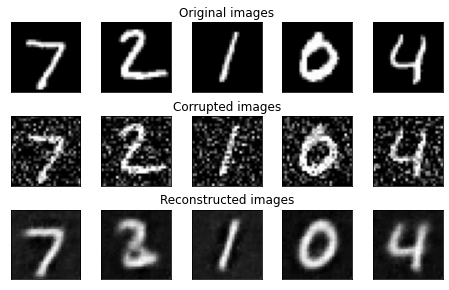

EPOCH 9/30
	 partial train loss (single batch): 0.051317
	 partial train loss (single batch): 0.050765
	 partial train loss (single batch): 0.051507
	 partial train loss (single batch): 0.052410
	 partial train loss (single batch): 0.051747
	 partial train loss (single batch): 0.050851
	 partial train loss (single batch): 0.051849
	 partial train loss (single batch): 0.051241
	 partial train loss (single batch): 0.051718
	 partial train loss (single batch): 0.051635
	 partial train loss (single batch): 0.051343
	 partial train loss (single batch): 0.051568
	 partial train loss (single batch): 0.052039
	 partial train loss (single batch): 0.051727
	 partial train loss (single batch): 0.051054
	 partial train loss (single batch): 0.051431
	 partial train loss (single batch): 0.050833
	 partial train loss (single batch): 0.051555
	 partial train loss (single batch): 0.050877
	 partial train loss (single batch): 0.050590
	 partial train loss (single batch): 0.051395
	 partial train loss (s

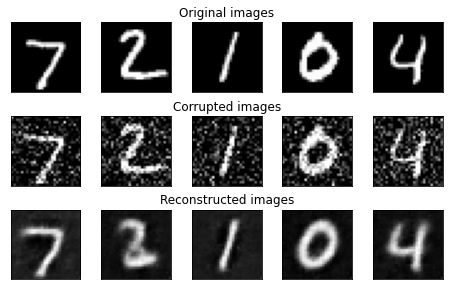

EPOCH 10/30
	 partial train loss (single batch): 0.051346
	 partial train loss (single batch): 0.050404
	 partial train loss (single batch): 0.051586
	 partial train loss (single batch): 0.052415
	 partial train loss (single batch): 0.051945
	 partial train loss (single batch): 0.050429
	 partial train loss (single batch): 0.051339
	 partial train loss (single batch): 0.051180
	 partial train loss (single batch): 0.051522
	 partial train loss (single batch): 0.051953
	 partial train loss (single batch): 0.051179
	 partial train loss (single batch): 0.051777
	 partial train loss (single batch): 0.051745
	 partial train loss (single batch): 0.051431
	 partial train loss (single batch): 0.051079
	 partial train loss (single batch): 0.051138
	 partial train loss (single batch): 0.050633
	 partial train loss (single batch): 0.051418
	 partial train loss (single batch): 0.050954
	 partial train loss (single batch): 0.050344
	 partial train loss (single batch): 0.051111
	 partial train loss (

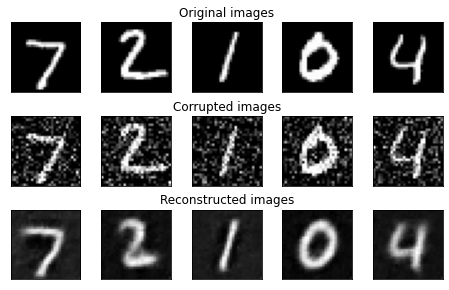

EPOCH 11/30
	 partial train loss (single batch): 0.051114
	 partial train loss (single batch): 0.049948
	 partial train loss (single batch): 0.051489
	 partial train loss (single batch): 0.051980
	 partial train loss (single batch): 0.051668
	 partial train loss (single batch): 0.050750
	 partial train loss (single batch): 0.051093
	 partial train loss (single batch): 0.050933
	 partial train loss (single batch): 0.051488
	 partial train loss (single batch): 0.051825
	 partial train loss (single batch): 0.051073
	 partial train loss (single batch): 0.051515
	 partial train loss (single batch): 0.051909
	 partial train loss (single batch): 0.050998
	 partial train loss (single batch): 0.050583
	 partial train loss (single batch): 0.051287
	 partial train loss (single batch): 0.050456
	 partial train loss (single batch): 0.051210
	 partial train loss (single batch): 0.050769
	 partial train loss (single batch): 0.050193
	 partial train loss (single batch): 0.050914
	 partial train loss (

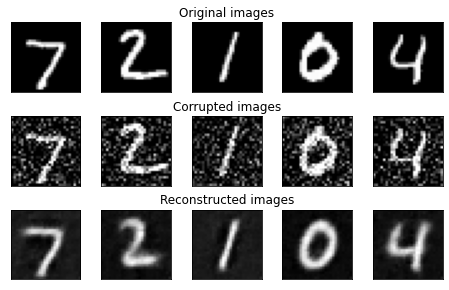

EPOCH 12/30
	 partial train loss (single batch): 0.050704
	 partial train loss (single batch): 0.049960
	 partial train loss (single batch): 0.051239
	 partial train loss (single batch): 0.052153
	 partial train loss (single batch): 0.051142
	 partial train loss (single batch): 0.050079
	 partial train loss (single batch): 0.051142
	 partial train loss (single batch): 0.050878
	 partial train loss (single batch): 0.051180
	 partial train loss (single batch): 0.051620
	 partial train loss (single batch): 0.050664
	 partial train loss (single batch): 0.051288
	 partial train loss (single batch): 0.051509
	 partial train loss (single batch): 0.051227
	 partial train loss (single batch): 0.050478
	 partial train loss (single batch): 0.051205
	 partial train loss (single batch): 0.050441
	 partial train loss (single batch): 0.051627
	 partial train loss (single batch): 0.050320
	 partial train loss (single batch): 0.050346
	 partial train loss (single batch): 0.050853
	 partial train loss (

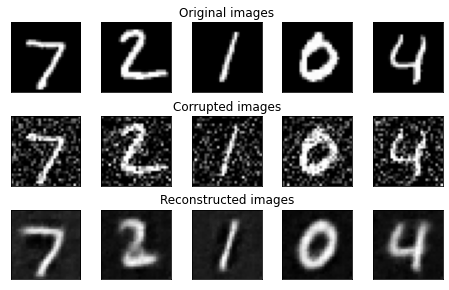

EPOCH 13/30
	 partial train loss (single batch): 0.050787
	 partial train loss (single batch): 0.049788
	 partial train loss (single batch): 0.050842
	 partial train loss (single batch): 0.051616
	 partial train loss (single batch): 0.051212
	 partial train loss (single batch): 0.050143
	 partial train loss (single batch): 0.051102
	 partial train loss (single batch): 0.050478
	 partial train loss (single batch): 0.051043
	 partial train loss (single batch): 0.051506
	 partial train loss (single batch): 0.050760
	 partial train loss (single batch): 0.051202
	 partial train loss (single batch): 0.051893
	 partial train loss (single batch): 0.050975
	 partial train loss (single batch): 0.050462
	 partial train loss (single batch): 0.050834
	 partial train loss (single batch): 0.050515
	 partial train loss (single batch): 0.051095
	 partial train loss (single batch): 0.050189
	 partial train loss (single batch): 0.050281
	 partial train loss (single batch): 0.050651
	 partial train loss (

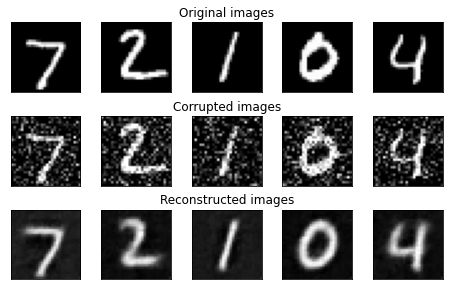

EPOCH 14/30
	 partial train loss (single batch): 0.050797
	 partial train loss (single batch): 0.050057
	 partial train loss (single batch): 0.050918
	 partial train loss (single batch): 0.051812
	 partial train loss (single batch): 0.051157
	 partial train loss (single batch): 0.050157
	 partial train loss (single batch): 0.050996
	 partial train loss (single batch): 0.050909
	 partial train loss (single batch): 0.050876
	 partial train loss (single batch): 0.051189
	 partial train loss (single batch): 0.050775
	 partial train loss (single batch): 0.050834
	 partial train loss (single batch): 0.051384
	 partial train loss (single batch): 0.050568
	 partial train loss (single batch): 0.050204
	 partial train loss (single batch): 0.050568
	 partial train loss (single batch): 0.050109
	 partial train loss (single batch): 0.050988
	 partial train loss (single batch): 0.050136
	 partial train loss (single batch): 0.050137
	 partial train loss (single batch): 0.050379
	 partial train loss (

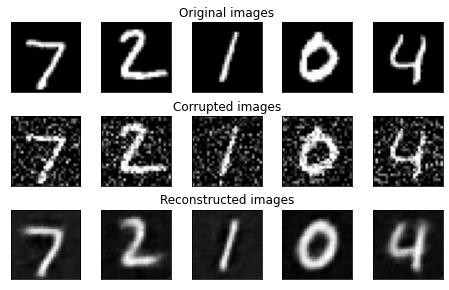

EPOCH 15/30
	 partial train loss (single batch): 0.050649
	 partial train loss (single batch): 0.050022
	 partial train loss (single batch): 0.050821
	 partial train loss (single batch): 0.051259
	 partial train loss (single batch): 0.050815
	 partial train loss (single batch): 0.049974
	 partial train loss (single batch): 0.050888
	 partial train loss (single batch): 0.050927
	 partial train loss (single batch): 0.050822
	 partial train loss (single batch): 0.050996
	 partial train loss (single batch): 0.050620
	 partial train loss (single batch): 0.050831
	 partial train loss (single batch): 0.051264
	 partial train loss (single batch): 0.050769
	 partial train loss (single batch): 0.050046
	 partial train loss (single batch): 0.051037
	 partial train loss (single batch): 0.050038
	 partial train loss (single batch): 0.051069
	 partial train loss (single batch): 0.050142
	 partial train loss (single batch): 0.049727
	 partial train loss (single batch): 0.050071
	 partial train loss (

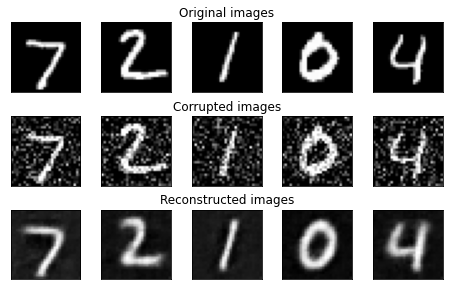

EPOCH 16/30
	 partial train loss (single batch): 0.050469
	 partial train loss (single batch): 0.049795
	 partial train loss (single batch): 0.050598
	 partial train loss (single batch): 0.051352
	 partial train loss (single batch): 0.050732
	 partial train loss (single batch): 0.049997
	 partial train loss (single batch): 0.050811
	 partial train loss (single batch): 0.050725
	 partial train loss (single batch): 0.050916
	 partial train loss (single batch): 0.050888
	 partial train loss (single batch): 0.050332
	 partial train loss (single batch): 0.050533
	 partial train loss (single batch): 0.051297
	 partial train loss (single batch): 0.050460
	 partial train loss (single batch): 0.050065
	 partial train loss (single batch): 0.050619
	 partial train loss (single batch): 0.050066
	 partial train loss (single batch): 0.051032
	 partial train loss (single batch): 0.049877
	 partial train loss (single batch): 0.049801
	 partial train loss (single batch): 0.050045
	 partial train loss (

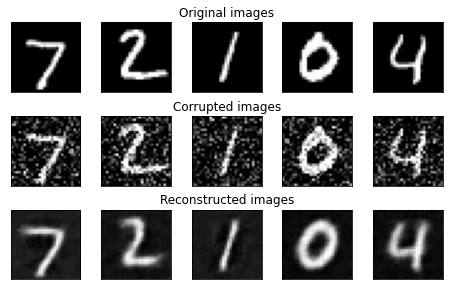

EPOCH 17/30
	 partial train loss (single batch): 0.050182
	 partial train loss (single batch): 0.049458
	 partial train loss (single batch): 0.050846
	 partial train loss (single batch): 0.051425
	 partial train loss (single batch): 0.050822
	 partial train loss (single batch): 0.050127
	 partial train loss (single batch): 0.050743
	 partial train loss (single batch): 0.050329
	 partial train loss (single batch): 0.050775
	 partial train loss (single batch): 0.051013
	 partial train loss (single batch): 0.050156
	 partial train loss (single batch): 0.050580
	 partial train loss (single batch): 0.051087
	 partial train loss (single batch): 0.050711
	 partial train loss (single batch): 0.049630
	 partial train loss (single batch): 0.050691
	 partial train loss (single batch): 0.049897
	 partial train loss (single batch): 0.050565
	 partial train loss (single batch): 0.049854
	 partial train loss (single batch): 0.049808
	 partial train loss (single batch): 0.050275
	 partial train loss (

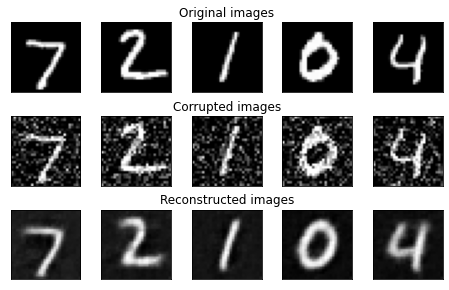

EPOCH 18/30
	 partial train loss (single batch): 0.050379
	 partial train loss (single batch): 0.049500
	 partial train loss (single batch): 0.050572
	 partial train loss (single batch): 0.051378
	 partial train loss (single batch): 0.050528
	 partial train loss (single batch): 0.050057
	 partial train loss (single batch): 0.050608
	 partial train loss (single batch): 0.050552
	 partial train loss (single batch): 0.050430
	 partial train loss (single batch): 0.050730
	 partial train loss (single batch): 0.050062
	 partial train loss (single batch): 0.050827
	 partial train loss (single batch): 0.050847
	 partial train loss (single batch): 0.050356
	 partial train loss (single batch): 0.049892
	 partial train loss (single batch): 0.050702
	 partial train loss (single batch): 0.049655
	 partial train loss (single batch): 0.050695
	 partial train loss (single batch): 0.049560
	 partial train loss (single batch): 0.049663
	 partial train loss (single batch): 0.050349
	 partial train loss (

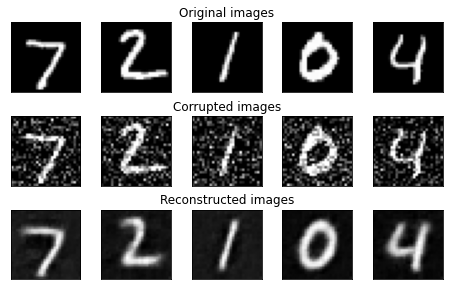

EPOCH 19/30
	 partial train loss (single batch): 0.050403
	 partial train loss (single batch): 0.049458
	 partial train loss (single batch): 0.050310
	 partial train loss (single batch): 0.051381
	 partial train loss (single batch): 0.050301
	 partial train loss (single batch): 0.049612
	 partial train loss (single batch): 0.050492
	 partial train loss (single batch): 0.050131
	 partial train loss (single batch): 0.050466
	 partial train loss (single batch): 0.050873
	 partial train loss (single batch): 0.049960
	 partial train loss (single batch): 0.050649
	 partial train loss (single batch): 0.051285
	 partial train loss (single batch): 0.050139
	 partial train loss (single batch): 0.049664
	 partial train loss (single batch): 0.050534
	 partial train loss (single batch): 0.049455
	 partial train loss (single batch): 0.050650
	 partial train loss (single batch): 0.049626
	 partial train loss (single batch): 0.049759
	 partial train loss (single batch): 0.050269
	 partial train loss (

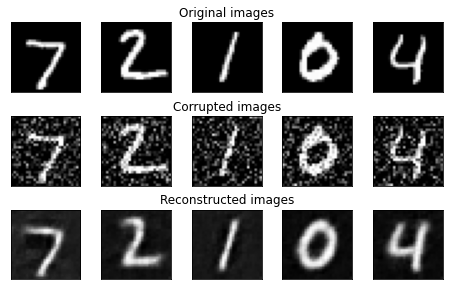

EPOCH 20/30
	 partial train loss (single batch): 0.049993
	 partial train loss (single batch): 0.049798
	 partial train loss (single batch): 0.050466
	 partial train loss (single batch): 0.050862
	 partial train loss (single batch): 0.050450
	 partial train loss (single batch): 0.049369
	 partial train loss (single batch): 0.050784
	 partial train loss (single batch): 0.050289
	 partial train loss (single batch): 0.050471
	 partial train loss (single batch): 0.050525
	 partial train loss (single batch): 0.049707
	 partial train loss (single batch): 0.050380
	 partial train loss (single batch): 0.050729
	 partial train loss (single batch): 0.050308
	 partial train loss (single batch): 0.049720
	 partial train loss (single batch): 0.050655
	 partial train loss (single batch): 0.049703
	 partial train loss (single batch): 0.050265
	 partial train loss (single batch): 0.050006
	 partial train loss (single batch): 0.049692
	 partial train loss (single batch): 0.050224
	 partial train loss (

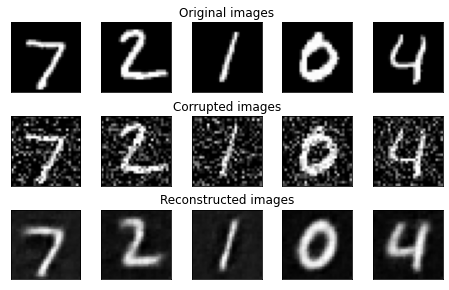

EPOCH 21/30
	 partial train loss (single batch): 0.049942
	 partial train loss (single batch): 0.049402
	 partial train loss (single batch): 0.050219
	 partial train loss (single batch): 0.051018
	 partial train loss (single batch): 0.050331
	 partial train loss (single batch): 0.049342
	 partial train loss (single batch): 0.050457
	 partial train loss (single batch): 0.050018
	 partial train loss (single batch): 0.050141
	 partial train loss (single batch): 0.050635
	 partial train loss (single batch): 0.050520
	 partial train loss (single batch): 0.050710
	 partial train loss (single batch): 0.050851
	 partial train loss (single batch): 0.049885
	 partial train loss (single batch): 0.049543
	 partial train loss (single batch): 0.050418
	 partial train loss (single batch): 0.049227
	 partial train loss (single batch): 0.050605
	 partial train loss (single batch): 0.049772
	 partial train loss (single batch): 0.049271
	 partial train loss (single batch): 0.050211
	 partial train loss (

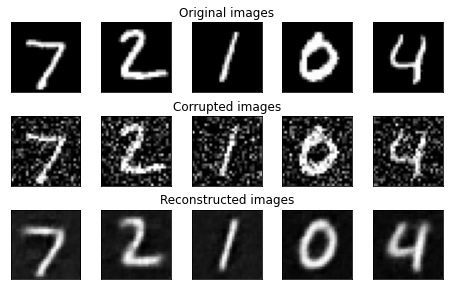

EPOCH 22/30
	 partial train loss (single batch): 0.050323
	 partial train loss (single batch): 0.049570
	 partial train loss (single batch): 0.050444
	 partial train loss (single batch): 0.050840
	 partial train loss (single batch): 0.050802
	 partial train loss (single batch): 0.049345
	 partial train loss (single batch): 0.050351
	 partial train loss (single batch): 0.050251
	 partial train loss (single batch): 0.050316
	 partial train loss (single batch): 0.050731
	 partial train loss (single batch): 0.049642
	 partial train loss (single batch): 0.050414
	 partial train loss (single batch): 0.050628
	 partial train loss (single batch): 0.050008
	 partial train loss (single batch): 0.049770
	 partial train loss (single batch): 0.050204
	 partial train loss (single batch): 0.049376
	 partial train loss (single batch): 0.050447
	 partial train loss (single batch): 0.049843
	 partial train loss (single batch): 0.049191
	 partial train loss (single batch): 0.049939
	 partial train loss (

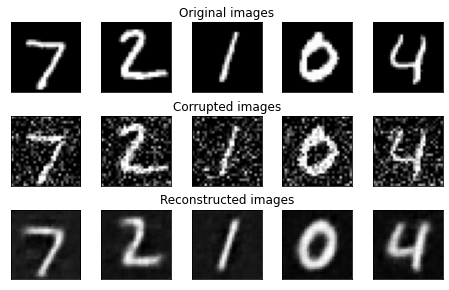

EPOCH 23/30
	 partial train loss (single batch): 0.050066
	 partial train loss (single batch): 0.049261
	 partial train loss (single batch): 0.050079
	 partial train loss (single batch): 0.050714
	 partial train loss (single batch): 0.050189
	 partial train loss (single batch): 0.049245
	 partial train loss (single batch): 0.050071
	 partial train loss (single batch): 0.050407
	 partial train loss (single batch): 0.050188
	 partial train loss (single batch): 0.050807
	 partial train loss (single batch): 0.049728
	 partial train loss (single batch): 0.049868
	 partial train loss (single batch): 0.050539
	 partial train loss (single batch): 0.050091
	 partial train loss (single batch): 0.049326
	 partial train loss (single batch): 0.050515
	 partial train loss (single batch): 0.049500
	 partial train loss (single batch): 0.050173
	 partial train loss (single batch): 0.049610
	 partial train loss (single batch): 0.049093
	 partial train loss (single batch): 0.049624
	 partial train loss (

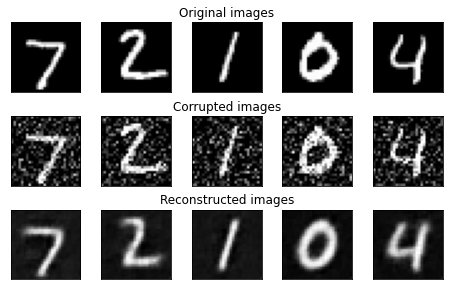

EPOCH 24/30
	 partial train loss (single batch): 0.049813
	 partial train loss (single batch): 0.049111
	 partial train loss (single batch): 0.050143
	 partial train loss (single batch): 0.050862
	 partial train loss (single batch): 0.050700
	 partial train loss (single batch): 0.049301
	 partial train loss (single batch): 0.050260
	 partial train loss (single batch): 0.050150
	 partial train loss (single batch): 0.049841
	 partial train loss (single batch): 0.050761
	 partial train loss (single batch): 0.049452
	 partial train loss (single batch): 0.050176
	 partial train loss (single batch): 0.050514
	 partial train loss (single batch): 0.049696
	 partial train loss (single batch): 0.049412
	 partial train loss (single batch): 0.050326
	 partial train loss (single batch): 0.049493
	 partial train loss (single batch): 0.049903
	 partial train loss (single batch): 0.049604
	 partial train loss (single batch): 0.049338
	 partial train loss (single batch): 0.049993
	 partial train loss (

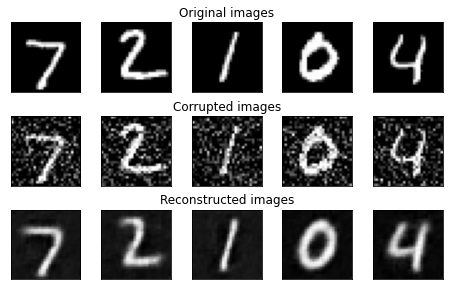

EPOCH 25/30
	 partial train loss (single batch): 0.049866
	 partial train loss (single batch): 0.049114
	 partial train loss (single batch): 0.050103
	 partial train loss (single batch): 0.050765
	 partial train loss (single batch): 0.050259
	 partial train loss (single batch): 0.049188
	 partial train loss (single batch): 0.050479
	 partial train loss (single batch): 0.049926
	 partial train loss (single batch): 0.050170
	 partial train loss (single batch): 0.050526
	 partial train loss (single batch): 0.049410
	 partial train loss (single batch): 0.050203
	 partial train loss (single batch): 0.050318
	 partial train loss (single batch): 0.049872
	 partial train loss (single batch): 0.049678
	 partial train loss (single batch): 0.049988
	 partial train loss (single batch): 0.049214
	 partial train loss (single batch): 0.050031
	 partial train loss (single batch): 0.049362
	 partial train loss (single batch): 0.049075
	 partial train loss (single batch): 0.049906
	 partial train loss (

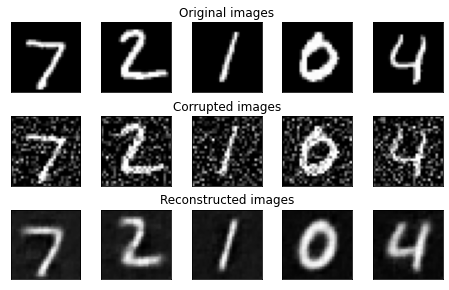

EPOCH 26/30
	 partial train loss (single batch): 0.049859
	 partial train loss (single batch): 0.049318
	 partial train loss (single batch): 0.049914
	 partial train loss (single batch): 0.050606
	 partial train loss (single batch): 0.050387
	 partial train loss (single batch): 0.049242
	 partial train loss (single batch): 0.050331
	 partial train loss (single batch): 0.049943
	 partial train loss (single batch): 0.050097
	 partial train loss (single batch): 0.050328
	 partial train loss (single batch): 0.049366
	 partial train loss (single batch): 0.050070
	 partial train loss (single batch): 0.050610
	 partial train loss (single batch): 0.049843
	 partial train loss (single batch): 0.049262
	 partial train loss (single batch): 0.049830
	 partial train loss (single batch): 0.049364
	 partial train loss (single batch): 0.050437
	 partial train loss (single batch): 0.049748
	 partial train loss (single batch): 0.049140
	 partial train loss (single batch): 0.049882
	 partial train loss (

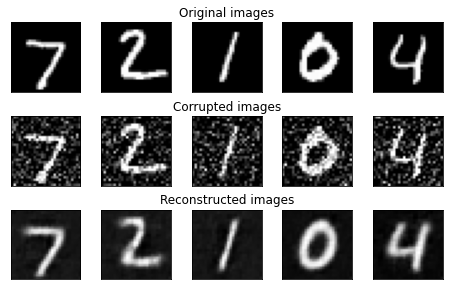

EPOCH 27/30
	 partial train loss (single batch): 0.049615
	 partial train loss (single batch): 0.048951
	 partial train loss (single batch): 0.049910
	 partial train loss (single batch): 0.051092
	 partial train loss (single batch): 0.050037
	 partial train loss (single batch): 0.049065
	 partial train loss (single batch): 0.049965
	 partial train loss (single batch): 0.049964
	 partial train loss (single batch): 0.049811
	 partial train loss (single batch): 0.050413
	 partial train loss (single batch): 0.049383
	 partial train loss (single batch): 0.050215
	 partial train loss (single batch): 0.050161
	 partial train loss (single batch): 0.049756
	 partial train loss (single batch): 0.049044
	 partial train loss (single batch): 0.049918
	 partial train loss (single batch): 0.049444
	 partial train loss (single batch): 0.050199
	 partial train loss (single batch): 0.049340
	 partial train loss (single batch): 0.049216
	 partial train loss (single batch): 0.049615
	 partial train loss (

EPOCH 28/30
	 partial train loss (single batch): 0.049923
	 partial train loss (single batch): 0.049170
	 partial train loss (single batch): 0.049915
	 partial train loss (single batch): 0.050866
	 partial train loss (single batch): 0.050404
	 partial train loss (single batch): 0.049338
	 partial train loss (single batch): 0.050037
	 partial train loss (single batch): 0.049931
	 partial train loss (single batch): 0.050023
	 partial train loss (single batch): 0.050647
	 partial train loss (single batch): 0.049494
	 partial train loss (single batch): 0.050120
	 partial train loss (single batch): 0.050234
	 partial train loss (single batch): 0.049694
	 partial train loss (single batch): 0.049437
	 partial train loss (single batch): 0.050041
	 partial train loss (single batch): 0.049202
	 partial train loss (single batch): 0.050158
	 partial train loss (single batch): 0.049566
	 partial train loss (single batch): 0.049124
	 partial train loss (single batch): 0.049772
	 partial train loss (

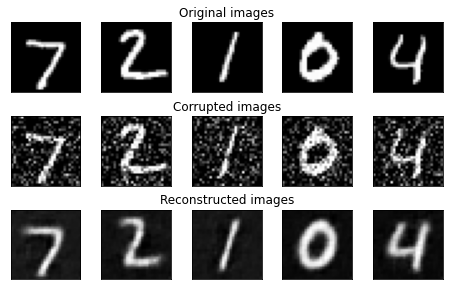

EPOCH 29/30
	 partial train loss (single batch): 0.049848
	 partial train loss (single batch): 0.048766
	 partial train loss (single batch): 0.049942
	 partial train loss (single batch): 0.050630
	 partial train loss (single batch): 0.050087
	 partial train loss (single batch): 0.049294
	 partial train loss (single batch): 0.050002
	 partial train loss (single batch): 0.049931
	 partial train loss (single batch): 0.049786
	 partial train loss (single batch): 0.050404
	 partial train loss (single batch): 0.049254
	 partial train loss (single batch): 0.050198
	 partial train loss (single batch): 0.050138
	 partial train loss (single batch): 0.049717
	 partial train loss (single batch): 0.048881
	 partial train loss (single batch): 0.050205
	 partial train loss (single batch): 0.048855
	 partial train loss (single batch): 0.050214
	 partial train loss (single batch): 0.049475
	 partial train loss (single batch): 0.049026
	 partial train loss (single batch): 0.049760
	 partial train loss (

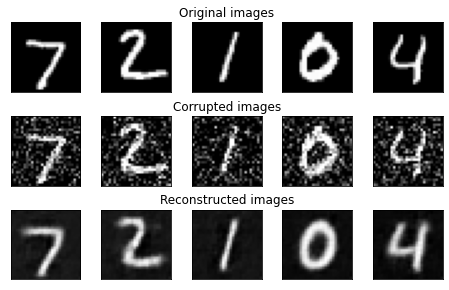

EPOCH 30/30
	 partial train loss (single batch): 0.049932
	 partial train loss (single batch): 0.049179
	 partial train loss (single batch): 0.050188
	 partial train loss (single batch): 0.050516
	 partial train loss (single batch): 0.050059
	 partial train loss (single batch): 0.049038
	 partial train loss (single batch): 0.050118
	 partial train loss (single batch): 0.049818
	 partial train loss (single batch): 0.049835
	 partial train loss (single batch): 0.050448
	 partial train loss (single batch): 0.049381
	 partial train loss (single batch): 0.050028
	 partial train loss (single batch): 0.050439
	 partial train loss (single batch): 0.049709
	 partial train loss (single batch): 0.049168
	 partial train loss (single batch): 0.050043
	 partial train loss (single batch): 0.049088
	 partial train loss (single batch): 0.049865
	 partial train loss (single batch): 0.049424
	 partial train loss (single batch): 0.048875
	 partial train loss (single batch): 0.050012
	 partial train loss (

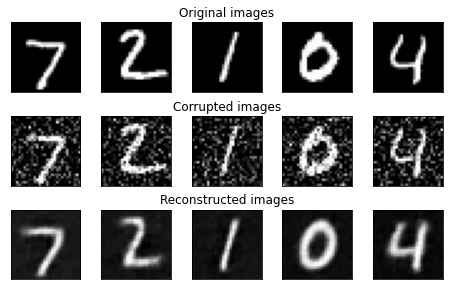

In [32]:
### Training cycle
noise_factor = 0.3
num_epochs = 30
history_da={'train_loss':[],'val_loss':[]}

for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    ### Training (use the training function)
    train_loss=train_epoch_den(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_loader, 
        loss_fn=loss_fn, 
        optimizer=optim,noise_factor=noise_factor)
    ### Validation  (use the testing function)
    val_loss = test_epoch_den(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=valid_loader, 
        loss_fn=loss_fn,noise_factor=noise_factor)
    # Print Validationloss
    history_da['train_loss'].append(train_loss)
    history_da['val_loss'].append(val_loss)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    plot_ae_outputs_den(encoder,decoder,noise_factor=noise_factor)


In [33]:
test_epoch_den(encoder,decoder,device,test_loader,loss_fn).item()

0.03831923380494118

## 4 Generate new samples

In [34]:
def plot_reconstructed(decoder, r0=(-5, 10), r1=(-10, 5), n=10):
    plt.figure(figsize=(20,8.5))
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1], cmap='gist_gray')

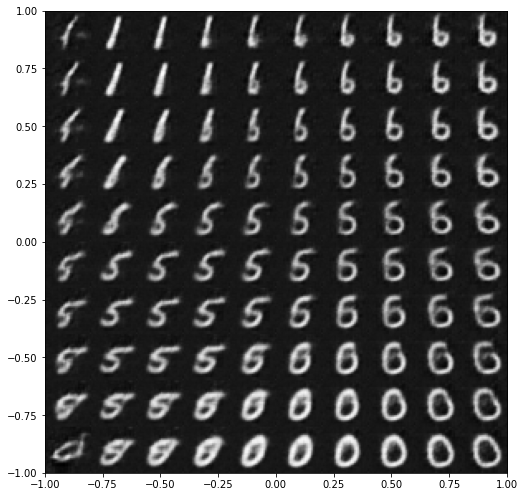

In [46]:
plot_reconstructed(decoder, r0=(-1, 1), r1=(-1, 1))

## 5 Visualize latent code

In [36]:
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

100%|██████████| 10000/10000 [00:06<00:00, 1541.44it/s]


In [37]:
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

Enc. Variable 0  Enc. Variable 1  Enc. Variable 2  Enc. Variable 3  label
0           -1.383118         0.764491        -1.320290        -1.885423      7
1           -0.782649         1.654276         1.984461        -0.672817      2
2           -1.288076         1.437014         0.055341        -0.102142      1
3            0.228016        -1.075041        -0.130099         0.245114      0
4           -0.000658        -0.332184        -1.181511         0.243641      4
...               ...              ...              ...              ...    ...
9995        -0.039099         0.546145         3.471843        -0.914478      2
9996         0.859481         0.176577         1.359074        -0.177347      3
9997        -1.071934         0.079422        -0.944979         0.149119      4
9998        -0.873066        -0.717308         0.431979         0.003050      5
9999         0.813999        -0.595941         0.822322         1.833026      6

[10000 rows x 5 columns]

In [47]:
px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

In [39]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

In [40]:
fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()